In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torch.utils import data
from torchvision import transforms
import glob
from PIL import Image

In [ ]:
torch.cuda.is_available()

True

In [ ]:
imgs_path = glob.glob('../input/anime-sketch-colorization-pair/data/train/*.png')

In [ ]:
len(imgs_path)

14224

In [ ]:
imgs_path[:4]

['../input/anime-sketch-colorization-pair/data/train/2041115.png',
 '../input/anime-sketch-colorization-pair/data/train/2909140.png',
 '../input/anime-sketch-colorization-pair/data/train/179059.png',
 '../input/anime-sketch-colorization-pair/data/train/2084052.png']

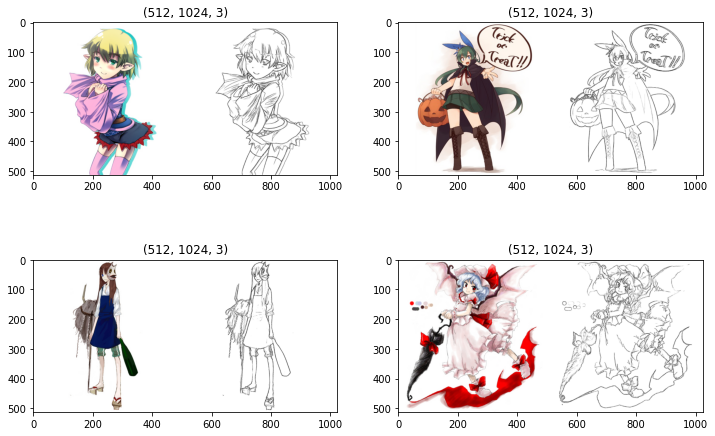

In [ ]:
plt.figure(figsize=(12,8))
for i, img_path in enumerate(imgs_path[:4]):
    img = Image.open(img_path)
    img = img.convert('RGB')
    np_img = np.array(img)
    plt.subplot(2, 2, i+1)
    plt.imshow(np_img)
    plt.title(str(np_img.shape))
plt.show()

In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 512)),
    transforms.Normalize(0.5, 0.5)
])

In [ ]:

class Anime_dataset(data.Dataset):
    def __init__(self, imgs_path):
        self.imgs_path = imgs_path

    def __getitem__(self, index):
        img_path = self.imgs_path[index]
        pil_img = Image.open(img_path)
        pil_img = pil_img.convert('RGB')
        pil_img = transform(pil_img)
        w = pil_img.size(2) // 2
        return pil_img[:, :, w:], pil_img[:, :, :w]

    def __len__(self):
        return len(self.imgs_path)

In [ ]:
dataset = Anime_dataset(imgs_path)
print(len(dataset))
batchsize = 64
dataloader = data.DataLoader(dataset, batch_size=batchsize, shuffle=True, pin_memory=True)

14224


torch.Size([64, 3, 256, 256])


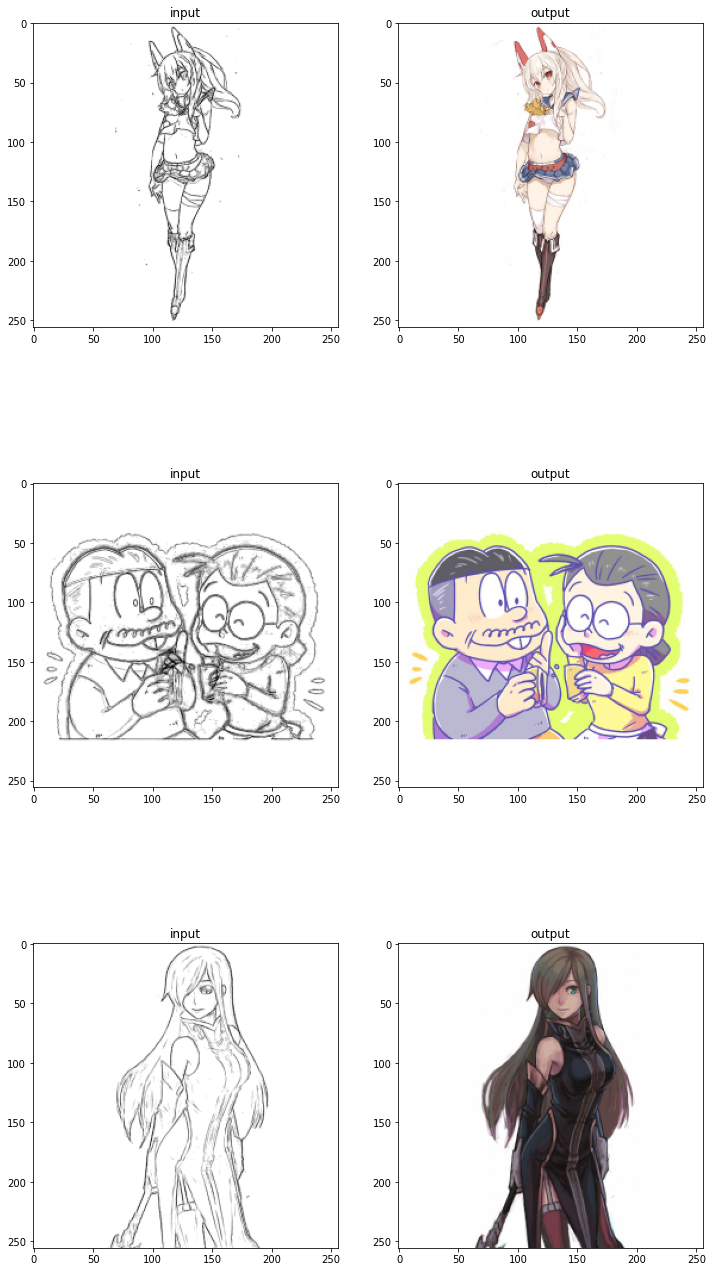

In [ ]:

imgs_batch, masks_batch = next(iter(dataloader))
print(imgs_batch.shape)

plt.figure(figsize=(12, 24))
for i, (img, mask) in enumerate(zip(imgs_batch[:3], masks_batch[:3])):
    img = (img.permute(1, 2, 0).numpy() + 1) / 2
    mask = (mask.permute(1, 2, 0).numpy() + 1) / 2
    plt.subplot(3, 2, 2*i+1)
    plt.title('input')
    plt.imshow(img)
    plt.subplot(3, 2, 2 * i + 2)
    plt.title('output')
    plt.imshow(mask)

plt.show()

In [ ]:

class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample, self).__init__()
        self.conv_relu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=3,
                      stride=2,
                      padding=1),
            nn.LeakyReLU(inplace=True),
        )
        self.bn = nn.BatchNorm2d(out_channels)


    def forward(self, x, is_bn=True):
        x = self.conv_relu(x)
        if is_bn:
            x = self.bn(x)
        return x

In [ ]:

class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Upsample, self).__init__()
        self.upconv_relu = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.LeakyReLU(inplace=True),
        )
        self.bn = nn.BatchNorm2d(out_channels)


    def forward(self, x, is_drop=False):
        x = self.upconv_relu(x)
        x = self.bn(x)
        if is_drop:
            x = F.dropout2d(x)
        return x

In [ ]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.down1 = Downsample(3, 64)
        self.down2 = Downsample(64, 128)
        self.down3 = Downsample(128, 256)
        self.down4 = Downsample(256, 512)
        self.down5 = Downsample(512, 512)
        self.down6 = Downsample(512, 512)


        self.up1 = Upsample(512, 512)

        self.up2 = Upsample(1024, 512)
        self.up3 = Upsample(1024, 256)
        self.up4 = Upsample(512, 128)
        self.up5 = Upsample(256, 64)

        self.last = nn.ConvTranspose2d(128, 3,
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1)

    def forward(self, x):

        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        x6 = self.down6(x5)


        x6 = self.up1(x6, is_drop=True)
        x6 = torch.cat([x6, x5], dim=1)

        x6 = self.up2(x6, is_drop=True)
        x6 = torch.cat([x6, x4], dim=1)

        x6 = self.up3(x6, is_drop=True)
        x6 = torch.cat([x6, x3], dim=1)


        x6 = self.up4(x6)
        x6 = torch.cat([x6, x2], dim=1)

        x6 = self.up5(x6)
        x6 = torch.cat([x6, x1], dim=1)

        x = torch.tanh(self.last(x6))
        return x

In [ ]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.down1 = Downsample(6, 64)
        self.down2 = Downsample(64, 128)
        self.cov1 = nn.Conv2d(128, 256, kernel_size=3)
        self.bn = nn.BatchNorm2d(256)
        self.last = nn.Conv2d(256, 1, kernel_size=3)

    def forward(self, img, mask):
        x = torch.cat([img, mask], dim=1)
        x = self.down1(x, is_bn=False)
        x = self.down2(x)
        x = F.dropout2d(self.bn(F.leaky_relu(self.cov1(x))))
        x = torch.sigmoid(self.last(x))
        return x

In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
G = Generator().to(device)
D = Discriminator().to(device)

G_optim = torch.optim.Adam(G.parameters(), lr=1e-3, betas=(0.5, 0.999))
D_optim = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))

In [ ]:

loss1 = torch.nn.BCELoss()
loss2 = torch.nn.L1Loss()
LAMBDA = 7

In [ ]:

def gen_img_plot(model, img, mask):

    predictions = np.squeeze(model(img).permute(0, 2, 3, 1).detach().cpu().numpy())
    img = img.permute(0, 2, 3, 1).cpu().numpy()
    mask = mask.permute(0, 2, 3, 1).cpu().numpy()
    plt.figure(figsize=(10, 10))
    display_list = [img[0], mask[0], predictions[0]]
    title = ['Input', 'truth', 'Output']
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])

        plt.imshow((display_list[i] + 1) / 2)
        plt.axis('off')

    plt.show()

In [ ]:

imgs_path_test = glob.glob('../input/anime-sketch-colorization-pair/data/val/*.png')
test_dataset = Anime_dataset(imgs_path_test)
test_dataloader = data.DataLoader(dataset, batch_size=batchsize)
imgs_batch, masks_batch = next(iter(test_dataloader))

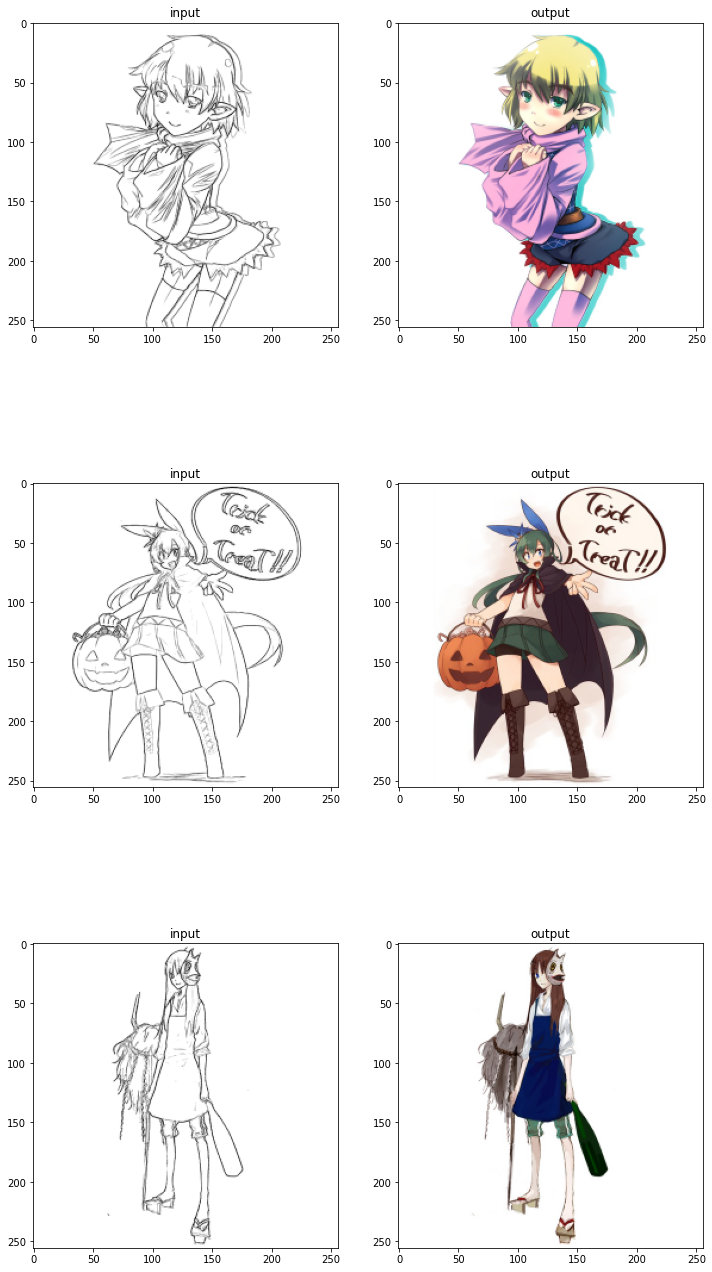

In [ ]:
plt.figure(figsize=(12, 24))
for i, (img, mask) in enumerate(zip(imgs_batch[:3], masks_batch[:3])):
    img = (img.permute(1, 2, 0).numpy() + 1) / 2
    mask = (mask.permute(1, 2, 0).numpy() + 1) / 2
    plt.subplot(3, 2, 2*i+1)
    plt.title('input')
    plt.imshow(img)
    plt.subplot(3, 2, 2 * i + 2)
    plt.title('output')
    plt.imshow(mask)

plt.show()
imgs_batch = imgs_batch.to(device)
masks_batch = masks_batch.to(device)

In [ ]:
D_loss_list = []
G_loss_list = []
D_acc_list = []

Epoch: 0, D_loss: 1.3860, G_loss: 1.6528, D_acc: 0.5320


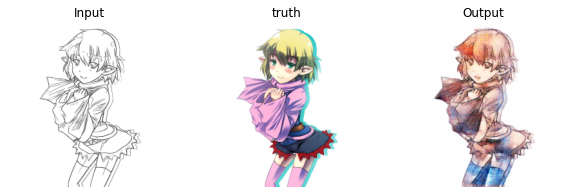

Epoch: 1, D_loss: 1.3826, G_loss: 1.5721, D_acc: 0.5331


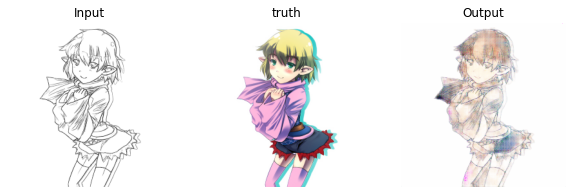

Epoch: 2, D_loss: 1.3823, G_loss: 1.5060, D_acc: 0.5294


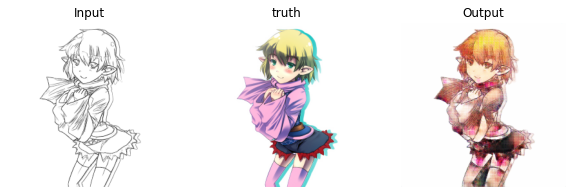

Epoch: 3, D_loss: 1.3826, G_loss: 1.4481, D_acc: 0.5173


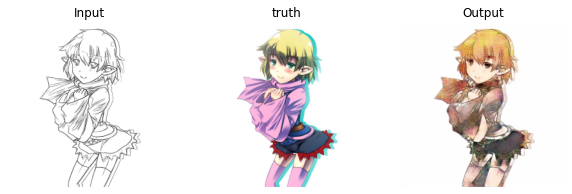

Epoch: 4, D_loss: 1.3824, G_loss: 1.4074, D_acc: 0.5228


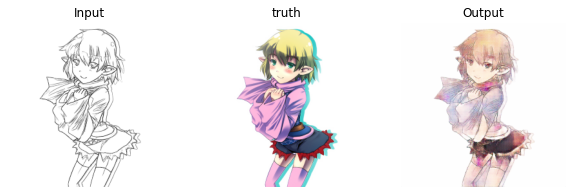

Epoch: 5, D_loss: 1.3820, G_loss: 1.4084, D_acc: 0.5257


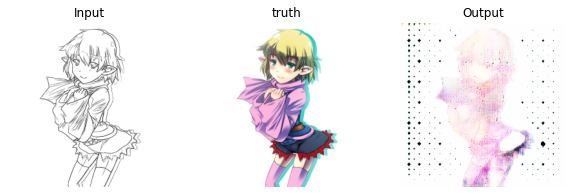

Epoch: 6, D_loss: 1.3831, G_loss: 1.4219, D_acc: 0.5228


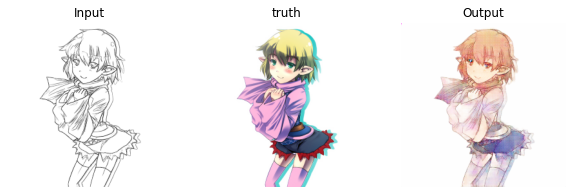

Epoch: 7, D_loss: 1.3832, G_loss: 1.3581, D_acc: 0.5156


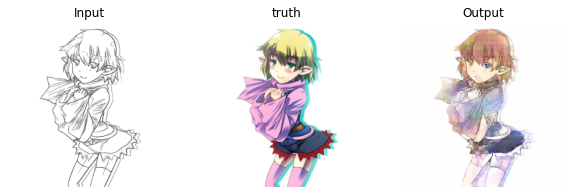

Epoch: 8, D_loss: 1.3825, G_loss: 1.3401, D_acc: 0.5189


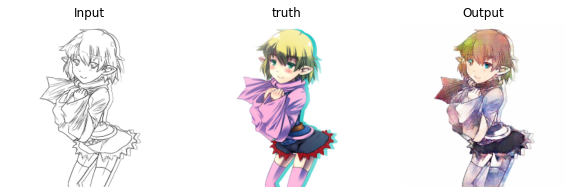

Epoch: 9, D_loss: 1.3834, G_loss: 1.3149, D_acc: 0.5130


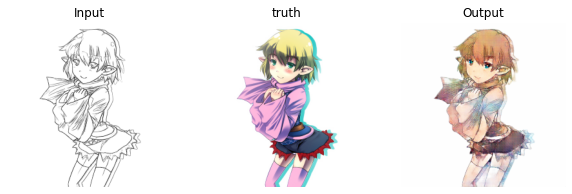

Epoch: 10, D_loss: 1.3833, G_loss: 1.3007, D_acc: 0.5127


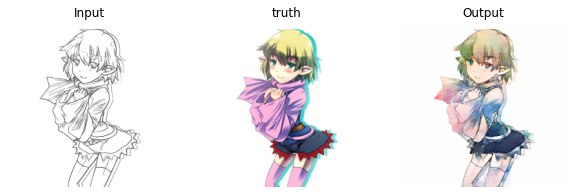

Epoch: 11, D_loss: 1.3832, G_loss: 1.2823, D_acc: 0.5163


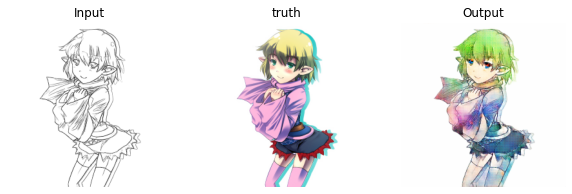

Epoch: 12, D_loss: 1.3842, G_loss: 1.2710, D_acc: 0.5051


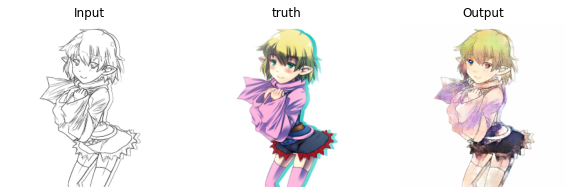

Epoch: 13, D_loss: 1.3829, G_loss: 1.2667, D_acc: 0.5105


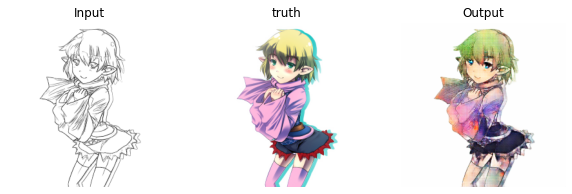

Epoch: 14, D_loss: 1.3834, G_loss: 1.2527, D_acc: 0.5115


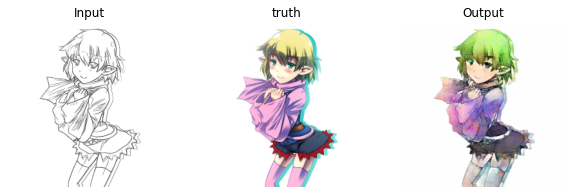

Epoch: 15, D_loss: 1.3834, G_loss: 1.2439, D_acc: 0.5089


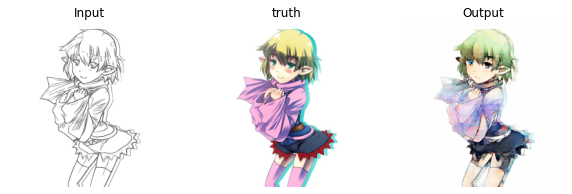

Epoch: 16, D_loss: 1.3829, G_loss: 1.2367, D_acc: 0.5113


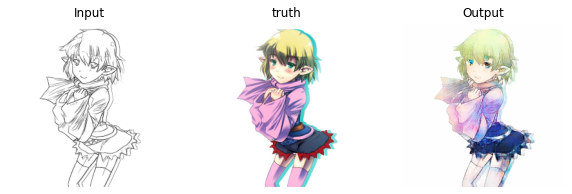

Epoch: 17, D_loss: 1.3836, G_loss: 1.2404, D_acc: 0.5095


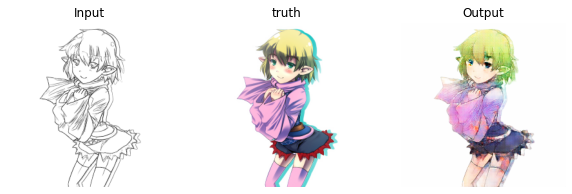

Epoch: 18, D_loss: 1.3839, G_loss: 1.2281, D_acc: 0.5054


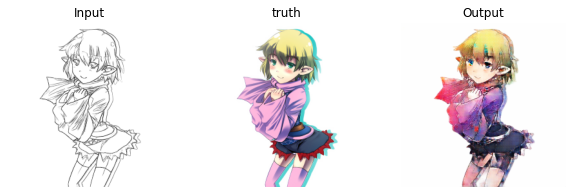

Epoch: 19, D_loss: 1.3821, G_loss: 1.2422, D_acc: 0.5087


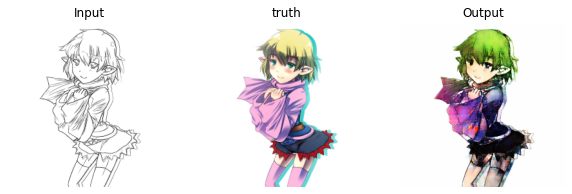

Epoch: 20, D_loss: 1.3825, G_loss: 1.2278, D_acc: 0.5116


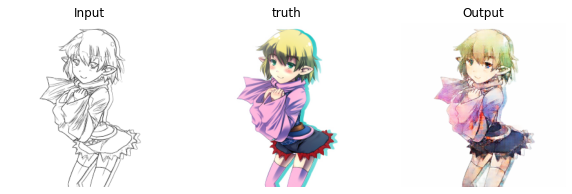

Epoch: 21, D_loss: 1.3832, G_loss: 1.2148, D_acc: 0.5102


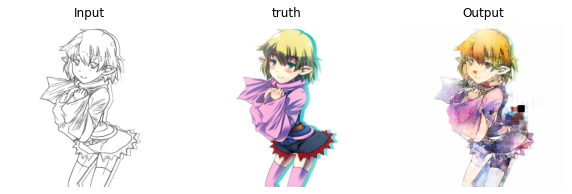

Epoch: 22, D_loss: 1.3838, G_loss: 1.2384, D_acc: 0.5076


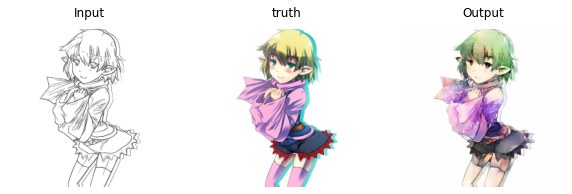

Epoch: 23, D_loss: 1.3822, G_loss: 1.2089, D_acc: 0.5122


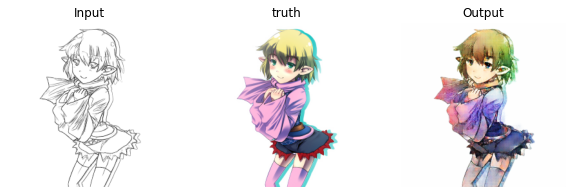

Epoch: 24, D_loss: 1.3826, G_loss: 1.2157, D_acc: 0.5172


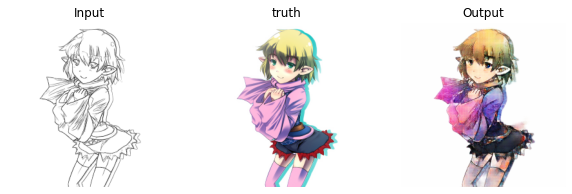

Epoch: 25, D_loss: 1.3840, G_loss: 1.2028, D_acc: 0.5076


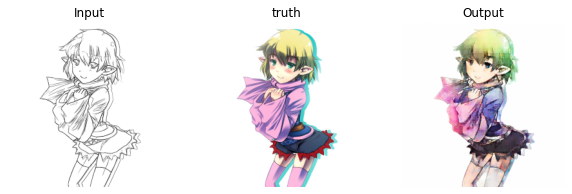

Epoch: 26, D_loss: 1.3830, G_loss: 1.1997, D_acc: 0.5135


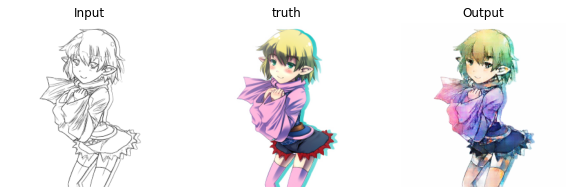

Epoch: 27, D_loss: 1.3831, G_loss: 1.1992, D_acc: 0.5096


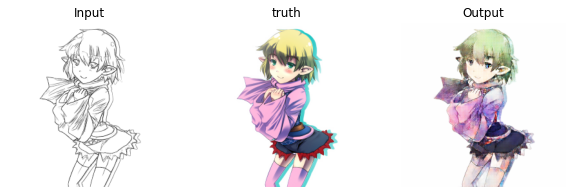

Epoch: 28, D_loss: 1.3837, G_loss: 1.1925, D_acc: 0.5088


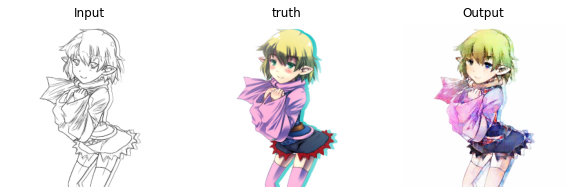

Epoch: 29, D_loss: 1.3829, G_loss: 1.1920, D_acc: 0.5102


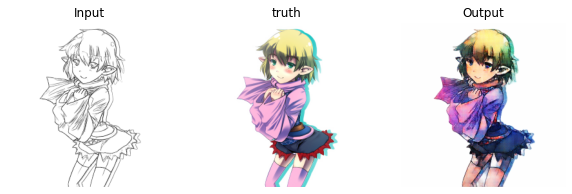

Epoch: 30, D_loss: 1.3835, G_loss: 1.1869, D_acc: 0.5077


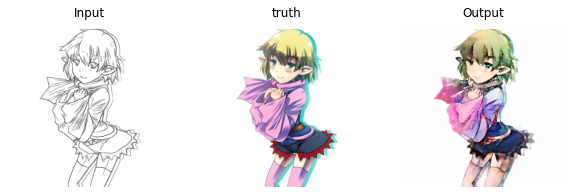

Epoch: 31, D_loss: 1.3839, G_loss: 1.1833, D_acc: 0.5114


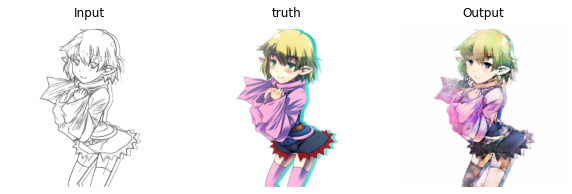

Epoch: 32, D_loss: 1.3840, G_loss: 1.1854, D_acc: 0.5072


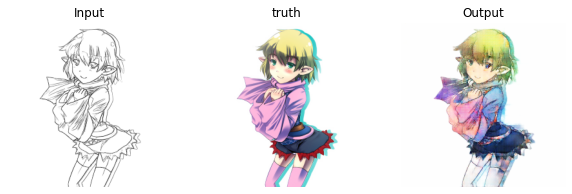

Epoch: 33, D_loss: 1.3826, G_loss: 1.2048, D_acc: 0.5127


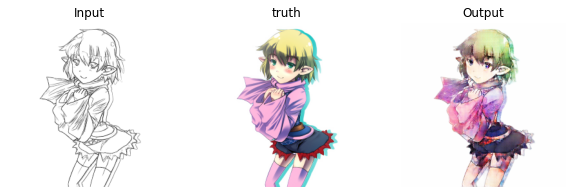

Epoch: 34, D_loss: 1.3827, G_loss: 1.1793, D_acc: 0.5189


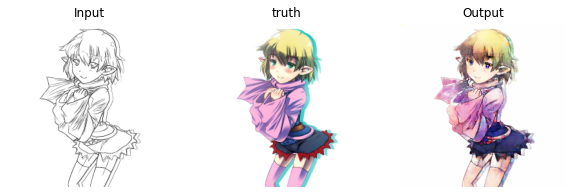

Epoch: 35, D_loss: 1.3833, G_loss: 1.1755, D_acc: 0.5150


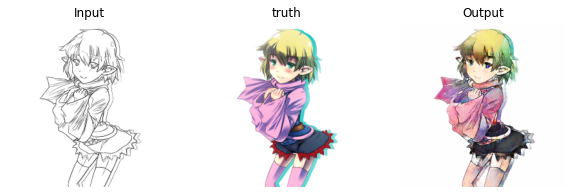

Epoch: 36, D_loss: 1.3835, G_loss: 1.1733, D_acc: 0.5120


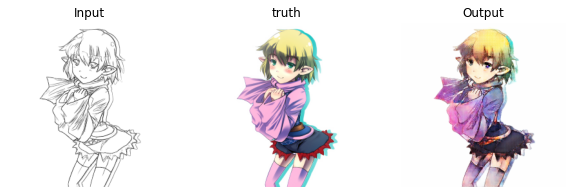

Epoch: 37, D_loss: 1.3836, G_loss: 1.1746, D_acc: 0.5122


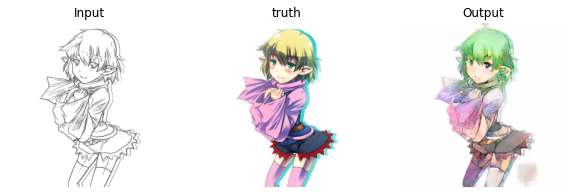

Epoch: 38, D_loss: 1.3830, G_loss: 1.1854, D_acc: 0.5091


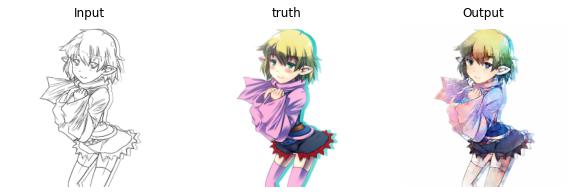

Epoch: 39, D_loss: 1.3832, G_loss: 1.1742, D_acc: 0.5114


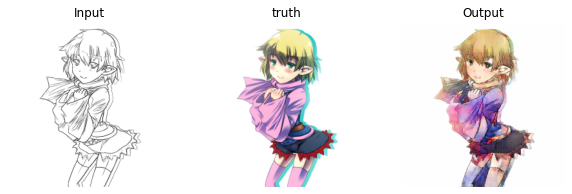

Epoch: 40, D_loss: 1.3830, G_loss: 1.1945, D_acc: 0.5109


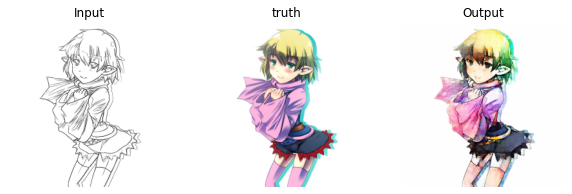

Epoch: 41, D_loss: 1.3837, G_loss: 1.1697, D_acc: 0.5083


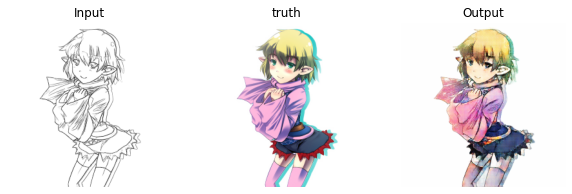

Epoch: 42, D_loss: 1.3826, G_loss: 1.1714, D_acc: 0.5180


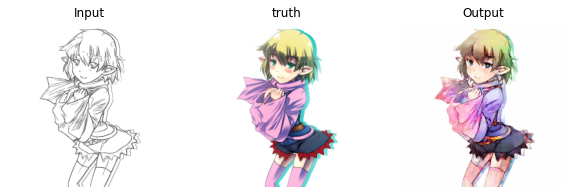

Epoch: 43, D_loss: 1.3825, G_loss: 1.1654, D_acc: 0.5161


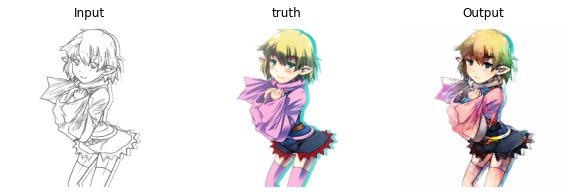

Epoch: 44, D_loss: 1.3819, G_loss: 1.1607, D_acc: 0.5216


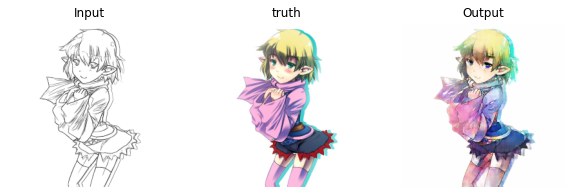

Epoch: 45, D_loss: 1.3828, G_loss: 1.1680, D_acc: 0.5094


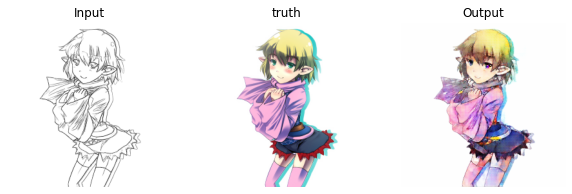

Epoch: 46, D_loss: 1.3828, G_loss: 1.1628, D_acc: 0.5160


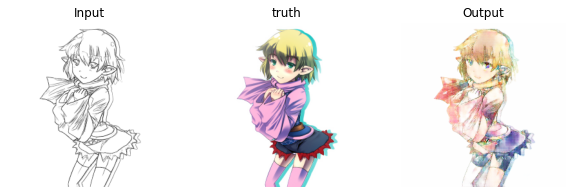

Epoch: 47, D_loss: 1.3813, G_loss: 1.2080, D_acc: 0.5196


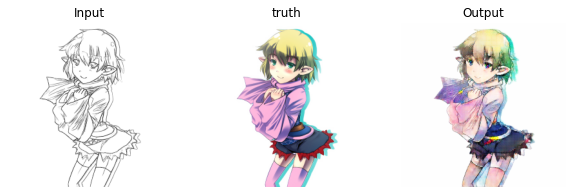

Epoch: 48, D_loss: 1.3823, G_loss: 1.1724, D_acc: 0.5167


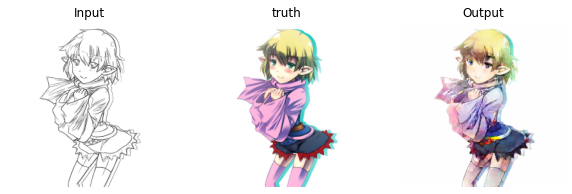

Epoch: 49, D_loss: 1.3821, G_loss: 1.1660, D_acc: 0.5182


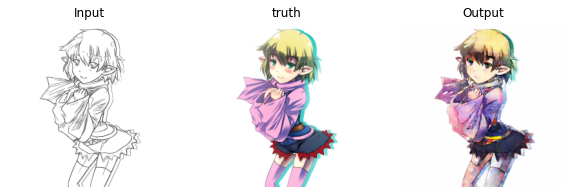

Epoch: 50, D_loss: 1.3823, G_loss: 1.1705, D_acc: 0.5195


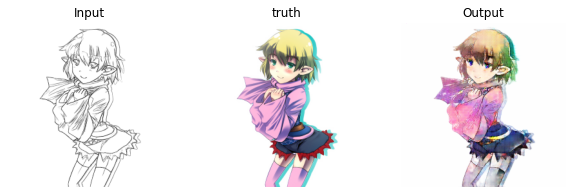

Epoch: 51, D_loss: 1.3819, G_loss: 1.1694, D_acc: 0.5174


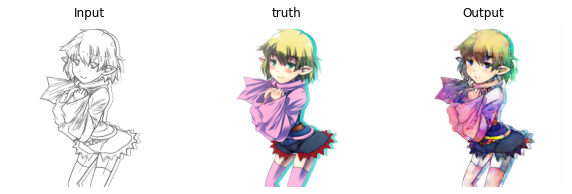

Epoch: 52, D_loss: 1.3815, G_loss: 1.1612, D_acc: 0.5202


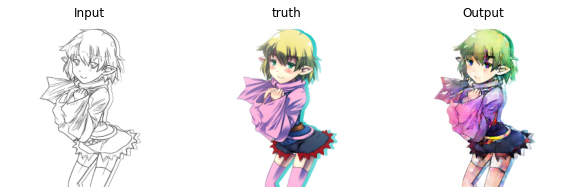

Epoch: 53, D_loss: 1.3826, G_loss: 1.1699, D_acc: 0.5187


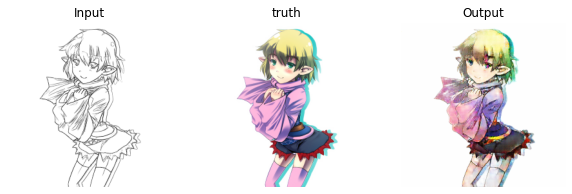

Epoch: 54, D_loss: 1.3815, G_loss: 1.1645, D_acc: 0.5179


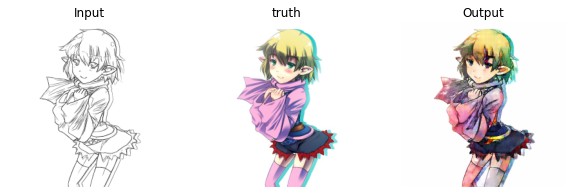

Epoch: 55, D_loss: 1.3812, G_loss: 1.1655, D_acc: 0.5202


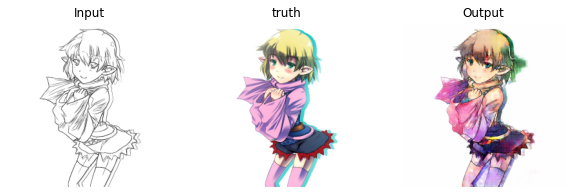

Epoch: 56, D_loss: 1.3798, G_loss: 1.1705, D_acc: 0.5269


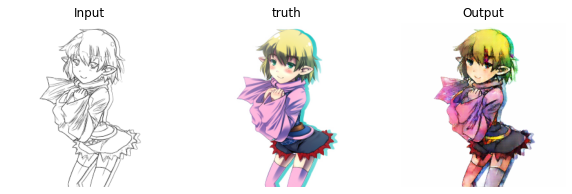

Epoch: 57, D_loss: 1.3803, G_loss: 1.1635, D_acc: 0.5255


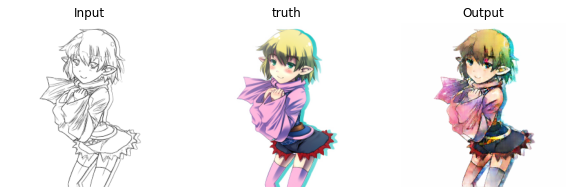

Epoch: 58, D_loss: 1.3794, G_loss: 1.1629, D_acc: 0.5258


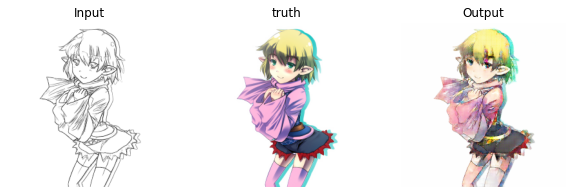

Epoch: 59, D_loss: 1.3795, G_loss: 1.1639, D_acc: 0.5278


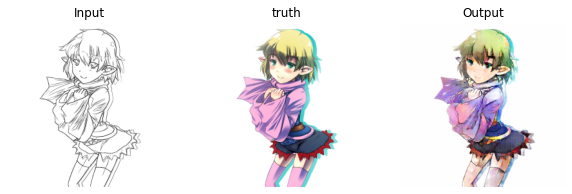

Epoch: 60, D_loss: 1.3775, G_loss: 1.1822, D_acc: 0.5310


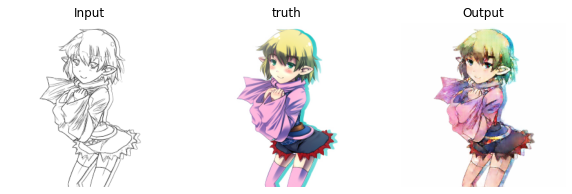

Epoch: 61, D_loss: 1.3775, G_loss: 1.1713, D_acc: 0.5363


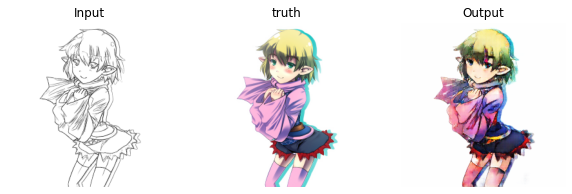

Epoch: 62, D_loss: 1.3780, G_loss: 1.1742, D_acc: 0.5392


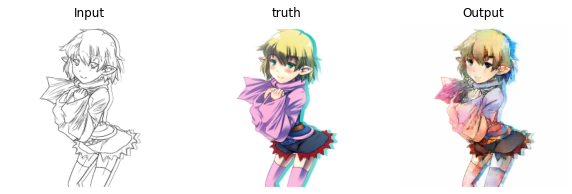

Epoch: 63, D_loss: 1.3792, G_loss: 1.1774, D_acc: 0.5370


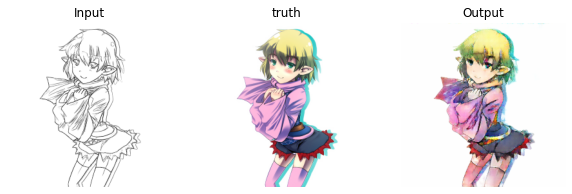

Epoch: 64, D_loss: 1.3778, G_loss: 1.1649, D_acc: 0.5309


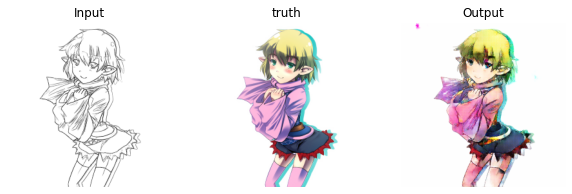

Epoch: 65, D_loss: 1.3765, G_loss: 1.1828, D_acc: 0.5372


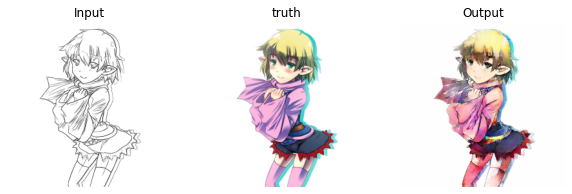

Epoch: 66, D_loss: 1.3773, G_loss: 1.1820, D_acc: 0.5408


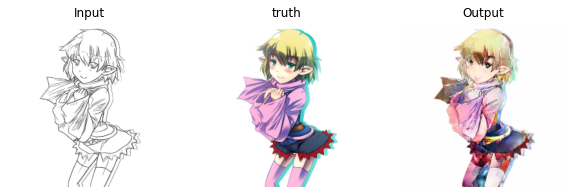

Epoch: 67, D_loss: 1.3715, G_loss: 1.1989, D_acc: 0.5562


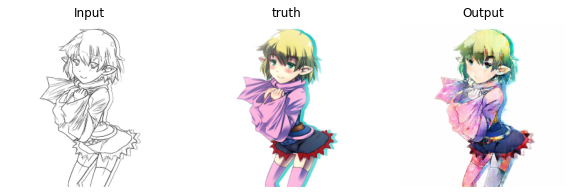

In [ ]:
for epoch in range(68):
    D_epoch_loss = 0
    G_epoch_loss = 0
    D_epoch_acc = 0
    count = len(dataloader)
    for step, (imgs, masks) in enumerate(dataloader):
        imgs = imgs.to(device)
        masks = masks.to(device)
        D_optim.zero_grad()
        D_real = D(imgs, masks)
        D_real_loss = loss1(D_real, torch.ones_like(D_real))
        D_real_loss.backward()
        G_img = G(imgs)

        D_fake = D(imgs, G_img.detach())
        D_fake_loss = loss1(D_fake, torch.zeros_like(D_fake))
        D_fake_loss.backward()

        D_loss = D_real_loss + D_fake_loss
        D_optim.step()

        G_loss = 0
        for _ in range(3):
            G_optim.zero_grad()
            G_img = G(imgs)

            D_fake = D(imgs, G_img)

            G_loss_BEC = loss1(D_fake, torch.ones_like(D_fake))
            G_loss_L1 = loss2(G_img, masks)

            G_loss = G_loss_BEC + LAMBDA * G_loss_L1
            G_loss.backward()
            G_optim.step()

        with torch.no_grad():
            D_epoch_loss += D_loss.item()
            G_epoch_loss += G_loss.item()

            D_real_acc = (D_real >= 0.5).float().mean().item()
            D_fake_acc = (D_fake < 0.5).float().mean().item()
            D_epoch_acc += (D_real_acc + D_fake_acc) / 2

    with torch.no_grad():
        D_epoch_loss /= count
        G_epoch_loss /= count
        D_epoch_acc /= count
        D_loss_list.append(D_epoch_loss)
        G_loss_list.append(G_epoch_loss)
        D_acc_list.append(D_epoch_acc)
        print(f'Epoch: {epoch}, D_loss: {D_epoch_loss:.4f}, G_loss: {G_epoch_loss:.4f}, D_acc: {D_epoch_acc:.4f}')
        gen_img_plot(G, imgs_batch, masks_batch)

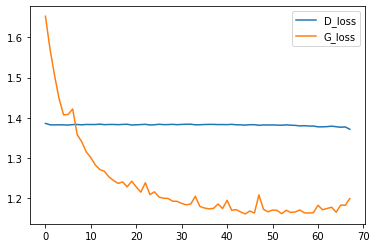

In [ ]:

plt.plot(D_loss_list, label='D_loss')
plt.plot(G_loss_list, label='G_loss')
plt.legend()
plt.show()

In [ ]:
torch.save(G.state_dict(), 'state_dict.pt')
torch.save(G, 'G.pt')